## Important - Do not use in production, for demonstration purposes only - please review the legal notices before continuing


## Legal Notices
This presentation, demonstration, and demonstration model are for informational purposes only. Microsoft makes no warranties, express or implied, in this presentation demonstration, and demonstration model. Nothing in this presentation, demonstration, or demonstration model modifies any of the terms and conditions of Microsoft's written and signed agreements. This is not an offer and applicable terms and the information provided is subject to revision and may be changed at any time by Microsoft.

This presentation, demonstration, and/or demonstration model do not give you or your organization any license to any patents, trademarks, copyrights, or other intellectual property covering the subject matter in this presentation, demonstration, and demonstration model.

The information contained in this presentation, demonstration and demonstration model represent the current view of Microsoft on the issues discussed as of the date of presentation and/or demonstration, and the duration of your access to the demonstration model. Because Microsoft must respond to changing market conditions, it should not be interpreted to be a commitment on the part of Microsoft, and Microsoft cannot guarantee the accuracy of any information presented after the date of presentation and/or demonstration and for the duration of your access to the demonstration model.

No Microsoft technology, nor any of its component technologies, including the demonstration model, is intended or made available: (1) as a medical device; (2) for the diagnosis of disease or other conditions, or in the cure, mitigation, treatment or prevention of a disease or other conditions; or (3) as a substitute for the professional clinical advice, opinion, or judgment of a treating healthcare professional. Partners or customers are responsible for ensuring the regulatory compliance of any solution they build using Microsoft technologies.

? 2020 Microsoft Corporation. All rights reserved

 

## Please don't run / don't click "Run all" the notebook:
At the time of writing of this document, the current core limit is 200 cores per workspace and depending upon number of concurrent users, you may end up with core capacity being exceeded or maximum number of parallel jobs being exceeded error. 
      

## AQI Forecasting

## Required Libraries

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

StatementMeta(Sustainability, 6, 1, Finished, Available)

## Loading data

In [7]:
db_name = "airqualitydb"
spark.sql(f"CREATE DATABASE IF NOT EXISTS {db_name}")

StatementMeta(Sustainability, 6, 2, Finished, Available)

DataFrame[]

In [8]:
%%spark
val df = spark.read.sqlanalytics("SustainabilityDW.dbo.Fact_Airquality") 
df.write.mode("overwrite").saveAsTable("airqualitydb.airquality")

StatementMeta(Sustainability, 6, 4, Finished, Available)

df: org.apache.spark.sql.DataFrame = [deploymentName: string, msrDeviceNbr: int ... 10 more fields]


In [9]:
%%pyspark
#spark.conf.set('spark.sql.execution.arrow.enabled', 'true)
## Scala dataframe is now accessible from PySpark
aqi_spark = spark.sql("select * from airqualitydb.airquality")
df = aqi_spark.toPandas()

df.head()

StatementMeta(Sustainability, 6, 5, Finished, Available)

,deploymentName,msrDeviceNbr,readingDateTimeLocal,latitude,longitude,tempC,humidity,pressure,pM25,pM10,pM1,aqi
0,*,2012,2020-08-23 08:08:37,41.397004,2.144207,16.2030029296875,51.05743408203125,98908.140625,9.021002769470215,9.813976287841797,7.758674144744873,57
1,*,2013,2020-07-13 20:50:14,41.459675,2.177003,13.644866943359375,70.416259765625,98926.3984375,2.921373128890991,2.921373128890991,2.7626259326934814,55
2,*,2087,2020-09-06 09:22:45,41.40329,2.164779,-0.294036865234375,74.15313720703125,99266.296875,18.80451774597168,23.952688217163086,13.858927726745605,81
3,*,2074,2021-09-09 21:18:29,41.378426,2.190101,6.4003753662109375,73.63739013671875,99261.4140625,28.97062873840332,28.970590591430664,27.396366119384766,87
4,*,2125,2021-06-17 23:18:36,41.81935577057992,-87.6846147423426,11.538009643554688,77.2430419921875,99277.5390625,3.1312499046325684,3.923576831817627,2.3572137355804443,13


In [10]:
df.info()

StatementMeta(Sustainability, 6, 6, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
deploymentName          100000 non-null object
msrDeviceNbr            100000 non-null int32
readingDateTimeLocal    100000 non-null datetime64[ns]
latitude                100000 non-null object
longitude               100000 non-null object
tempC                   100000 non-null object
humidity                100000 non-null object
pressure                100000 non-null object
pM25                    100000 non-null object
pM10                    100000 non-null object
pM1                     100000 non-null object
aqi                     100000 non-null int32
dtypes: datetime64[ns](1), int32(2), object(9)
memory usage: 8.4+ MB


## Preprocess data

In [11]:
convert_dict = {'aqi': float, 'tempC': float, 'humidity': float, 'pressure': float, 'pM25': float, 'pM10': float, 'pM1': float}
df = df.astype(convert_dict)
df = df[['readingDateTimeLocal', 'aqi', 'tempC', 'humidity', 'pressure', 'pM25', 'pM10', 'pM1']]

df['readingDateTimeLocal'] = pd.to_datetime(df['readingDateTimeLocal'])
df.sort_values(by='readingDateTimeLocal', inplace=True)

df['readingDateTimeLocal'] = df['readingDateTimeLocal'].dt.strftime('%Y-%m-%d')
df.tail()

StatementMeta(Sustainability, 6, 7, Finished, Available)

,readingDateTimeLocal,aqi,tempC,humidity,pressure,pM25,pM10,pM1
54651,2022-01-01,27.0,12.373810,73.348999,98771.460938,6.679182,6.679191,6.316241
23551,2022-01-01,9.0,-5.087204,54.347229,99379.710938,2.290184,2.962982,1.652949
50893,2022-01-01,35.0,-7.300873,56.750488,99908.648438,8.435266,14.064587,3.686422
36719,2022-01-01,16.0,1.708679,45.863342,100232.164062,4.017947,4.783027,3.216497
71944,2022-01-01,26.0,7.796936,71.501160,99093.265625,6.284548,6.284548,5.943050


In [12]:
df1 = df.groupby(by='readingDateTimeLocal')[['aqi', 'tempC', 'humidity', 'pressure', 'pM25', 'pM10', 'pM1']].mean().reset_index()
df1.columns = ['ds', 'y', 'tempC', 'humidity', 'pressure', 'pM25', 'pM10', 'pM1']
#df_aqi_1['cap'] = df_aqi_1['y'].max()
df1['ds'] = pd.to_datetime(df1['ds'])
df1

StatementMeta(Sustainability, 6, 8, Finished, Available)

,ds,y,tempC,humidity,pressure,pM25,pM10,pM1
0,2020-01-01,61.551724,6.575463,63.858453,99210.293777,6.982878,8.098360,5.708305
1,2020-01-02,63.576000,6.391061,65.418970,99193.916563,7.540225,8.868874,6.053961
2,2020-01-03,66.000000,6.676760,66.030548,99094.243129,8.228336,9.595681,6.681353
3,2020-01-04,64.400000,5.553241,65.876261,98990.498553,7.830538,9.348148,6.188685
4,2020-01-05,67.266129,6.281871,65.399994,99047.158833,8.665529,10.215888,6.970306
...,...,...,...,...,...,...,...,...
727,2021-12-28,29.248276,6.978355,64.864270,99035.248869,7.626565,8.854766,6.252657
728,2021-12-29,28.503597,5.974858,66.024539,98975.998370,7.440707,8.741601,6.027293
729,2021-12-30,31.593220,6.469599,65.029856,99030.062301,8.656867,10.212630,6.948903
730,2021-12-31,30.977273,7.098231,65.230838,98994.941998,8.276494,9.541571,6.830574


## Sampling

In [13]:
break_date = pd.Timestamp("2021-01-01")
aqi_train_data = df1[df1['ds'] > break_date]
#train_data.set_index('ds', inplace=True)
#test_data.set_index('ds', inplace=True)
aqi_train_data

StatementMeta(Sustainability, 6, 9, Finished, Available)

,ds,y,tempC,humidity,pressure,pM25,pM10,pM1
367,2021-01-02,31.679487,7.145779,66.699062,99066.890675,8.484172,9.682405,7.089368
368,2021-01-03,33.617021,6.441282,65.104123,99059.808178,9.092532,10.810233,7.252858
369,2021-01-04,28.487395,7.843139,62.593399,99086.541557,7.470565,8.706114,6.097375
370,2021-01-05,29.428571,5.179825,68.014668,98994.936551,7.862091,9.241059,6.303708
371,2021-01-06,31.455882,5.946426,67.447247,98990.484432,8.405033,10.083484,6.606252
...,...,...,...,...,...,...,...,...
727,2021-12-28,29.248276,6.978355,64.864270,99035.248869,7.626565,8.854766,6.252657
728,2021-12-29,28.503597,5.974858,66.024539,98975.998370,7.440707,8.741601,6.027293
729,2021-12-30,31.593220,6.469599,65.029856,99030.062301,8.656867,10.212630,6.948903
730,2021-12-31,30.977273,7.098231,65.230838,98994.941998,8.276494,9.541571,6.830574


In [14]:
%%spark
val df = spark.read.synapsesql("SustainabilityDW.dbo.aqi_test_df") 
df.write.mode("overwrite").saveAsTable("airqualitydb.aqi_test_df")

StatementMeta(Sustainability, 6, 10, Finished, Available)

df: org.apache.spark.sql.DataFrame = [ds: string, y: string ... 6 more fields]


In [15]:
%%pyspark
#spark.conf.set('spark.sql.execution.arrow.enabled', 'true)
## Scala dataframe is now accessible from PySpark
aqi_spark = spark.sql("SELECT * FROM `airqualitydb`.`aqi_test_df`")
df_aqi_test = aqi_spark.toPandas()
df_aqi_test.sort_values(by='ds', inplace=True)

StatementMeta(Sustainability, 6, 11, Finished, Available)

In [16]:
df_aqi_test['ds'] = pd.to_datetime(df_aqi_test['ds'])
#df_aqi_test['ds'] = df_aqi_test['ds'].dt.strftime('%Y-%m-%d')
convert_dict = {'y': float, 'tempC': float, 'humidity': float, 'pressure': float, 'pM25': float, 'pM10': float, 'pM1': float}
df_aqi_test = df_aqi_test.astype(convert_dict)

StatementMeta(Sustainability, 6, 12, Finished, Available)

In [17]:
aqi_train_data.columns
df_aqi_test.columns

StatementMeta(Sustainability, 6, 13, Finished, Available)

Index(['ds', 'y', 'tempC', 'humidity', 'pressure', 'pM25', 'pM10', 'pM1'], dtype='object')

In [18]:
df_final =aqi_train_data.append(df_aqi_test).reset_index()
df_final.sort_values(by='ds', inplace=True)
df_final

StatementMeta(Sustainability, 6, 14, Finished, Available)

,index,ds,y,tempC,humidity,pressure,pM25,pM10,pM1
0,367,2021-01-02,31.679487,7.145779,66.699062,99066.890675,8.484172,9.682405,7.089368
1,368,2021-01-03,33.617021,6.441282,65.104123,99059.808178,9.092532,10.810233,7.252858
2,369,2021-01-04,28.487395,7.843139,62.593399,99086.541557,7.470565,8.706114,6.097375
3,370,2021-01-05,29.428571,5.179825,68.014668,98994.936551,7.862091,9.241059,6.303708
4,371,2021-01-06,31.455882,5.946426,67.447247,98990.484432,8.405033,10.083484,6.606252
...,...,...,...,...,...,...,...,...,...
460,46,2022-04-06,28.759038,12.005925,71.696244,97791.273210,11.029497,12.580942,9.219918
461,76,2022-04-07,30.969768,7.734676,62.465932,97884.129170,2.804483,3.619824,2.013231
462,32,2022-04-08,31.597454,5.142223,78.711971,98144.659180,4.179910,5.242225,3.122858
463,4,2022-04-09,29.765294,4.715402,69.320967,98769.515790,3.835986,4.943377,2.761102


In [19]:
# Remove column name 'A'
df_final = df_final.drop(['index'], axis = 1)
df_final

StatementMeta(Sustainability, 6, 15, Finished, Available)

,ds,y,tempC,humidity,pressure,pM25,pM10,pM1
0,2021-01-02,31.679487,7.145779,66.699062,99066.890675,8.484172,9.682405,7.089368
1,2021-01-03,33.617021,6.441282,65.104123,99059.808178,9.092532,10.810233,7.252858
2,2021-01-04,28.487395,7.843139,62.593399,99086.541557,7.470565,8.706114,6.097375
3,2021-01-05,29.428571,5.179825,68.014668,98994.936551,7.862091,9.241059,6.303708
4,2021-01-06,31.455882,5.946426,67.447247,98990.484432,8.405033,10.083484,6.606252
...,...,...,...,...,...,...,...,...
460,2022-04-06,28.759038,12.005925,71.696244,97791.273210,11.029497,12.580942,9.219918
461,2022-04-07,30.969768,7.734676,62.465932,97884.129170,2.804483,3.619824,2.013231
462,2022-04-08,31.597454,5.142223,78.711971,98144.659180,4.179910,5.242225,3.122858
463,2022-04-09,29.765294,4.715402,69.320967,98769.515790,3.835986,4.943377,2.761102


## Plot data

StatementMeta(Sustainability, 6, 16, Finished, Available)

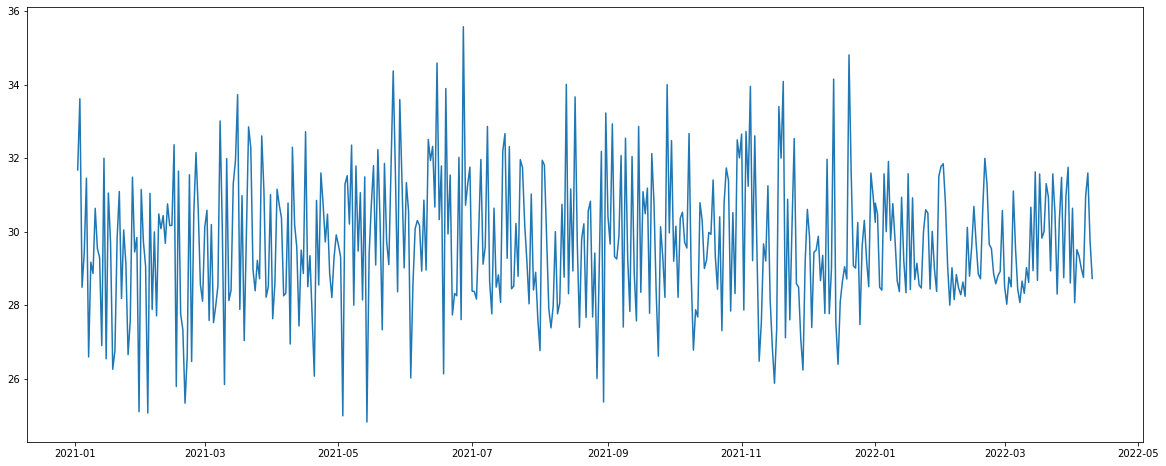

In [20]:
plt.figure(figsize=(20,8))
plt.plot(df_final['ds'], df_final['y'])
plt.show()

StatementMeta(Sustainability, 6, 17, Finished, Available)

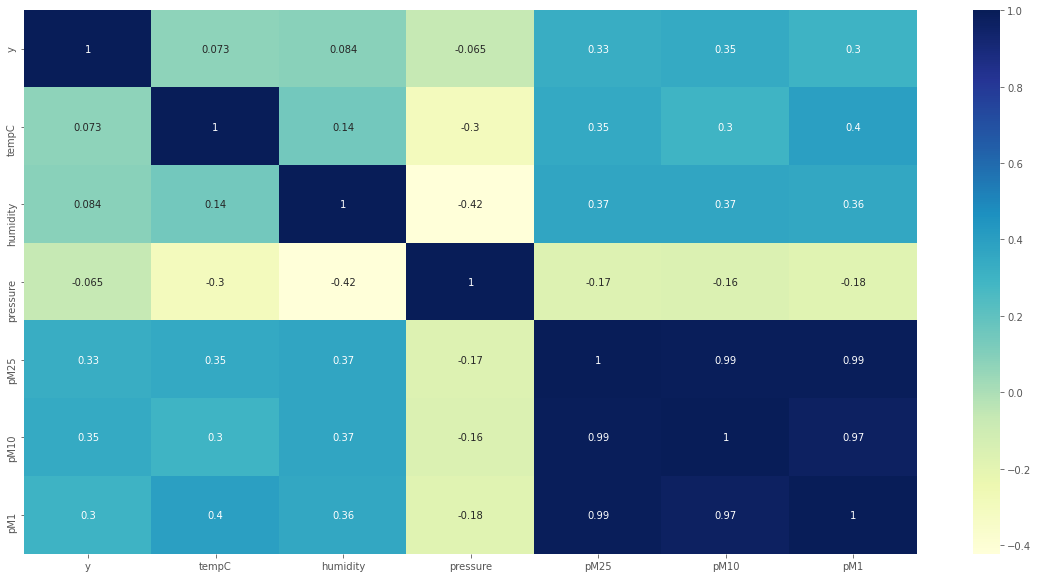

In [21]:
# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')
dataplot = sns.heatmap(df_final.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [22]:
break_date = pd.Timestamp("2022-01-01")
train_data = df_final[df_final['ds'] < break_date][['ds', 'y']]
test_data = df_final[df_final['ds'] >= break_date][['ds', 'y']]
train_data.set_index('ds', inplace=True)
test_data.set_index('ds', inplace=True)
train_data.shape, test_data.shape

StatementMeta(Sustainability, 6, 18, Finished, Available)

((364, 1), (101, 1))

## ARIMA Model 

In [23]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      #d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      #D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

StatementMeta(Sustainability, 6, 19, Finished, Available)

Fit ARIMA: order=(0, 0, 0); AIC=1538.975, BIC=1546.769, Fit time=0.073 seconds
Fit ARIMA: order=(1, 0, 0); AIC=1539.504, BIC=1551.195, Fit time=0.225 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1539.624, BIC=1551.315, Fit time=0.026 seconds
Fit ARIMA: order=(1, 0, 1); AIC=1539.684, BIC=1555.273, Fit time=0.108 seconds
Total fit time: 0.584 seconds
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  364
Model:                     ARMA(0, 0)   Log Likelihood                -767.488
Method:                           css   S.D. of innovations              1.993
Date:                Wed, 19 Oct 2022   AIC                           1538.975
Time:                        08:09:39   BIC                           1546.769
Sample:                             0   HQIC                          1542.073
                                                                              
                 coef 

## ARIMA Model Results

In [24]:
# fit ARIMA model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data, order=(1,0,0)) 
results = model.fit() 

print(results.summary())

StatementMeta(Sustainability, 6, 20, Finished, Available)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  364
Model:                     ARMA(1, 0)   Log Likelihood                -766.752
Method:                       css-mle   S.D. of innovations              1.989
Date:                Wed, 19 Oct 2022   AIC                           1539.504
Time:                        08:09:45   BIC                           1551.195
Sample:                    01-02-2021   HQIC                          1544.150
                         - 12-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7206      0.098    303.184      0.000      29.528      29.913
ar.L1.y       -0.0635      0.052     -1.214      0.225      -0.166       0.039
                                    Roots           

## Plot residual errors

StatementMeta(Sustainability, 6, 21, Finished, Available)

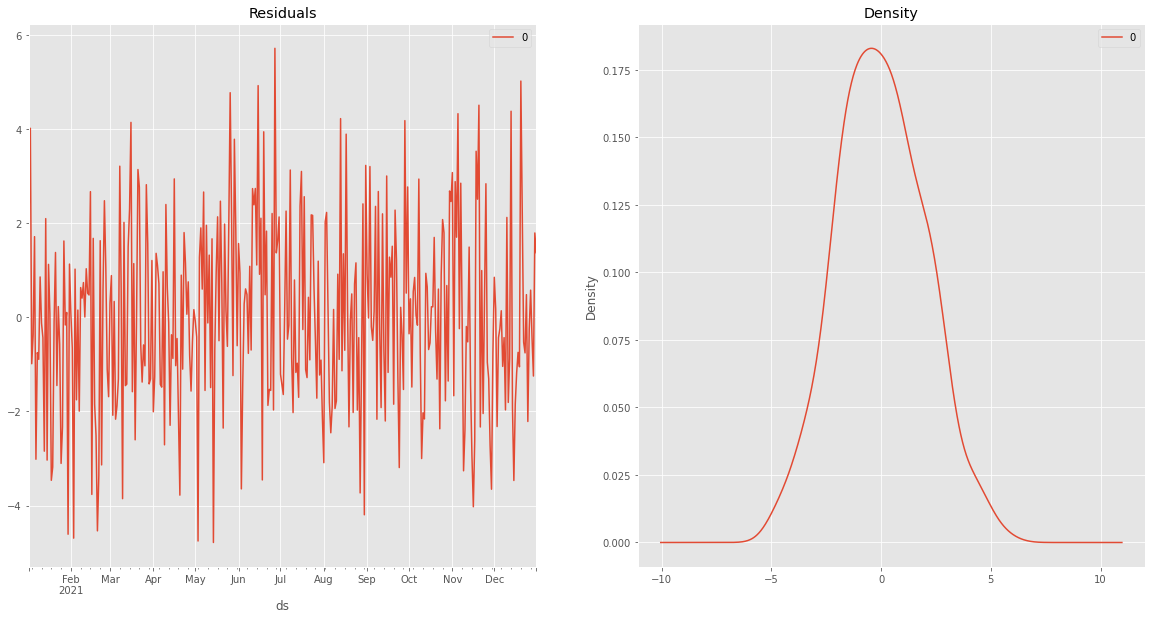

In [25]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

StatementMeta(Sustainability, 6, 22, Finished, Available)

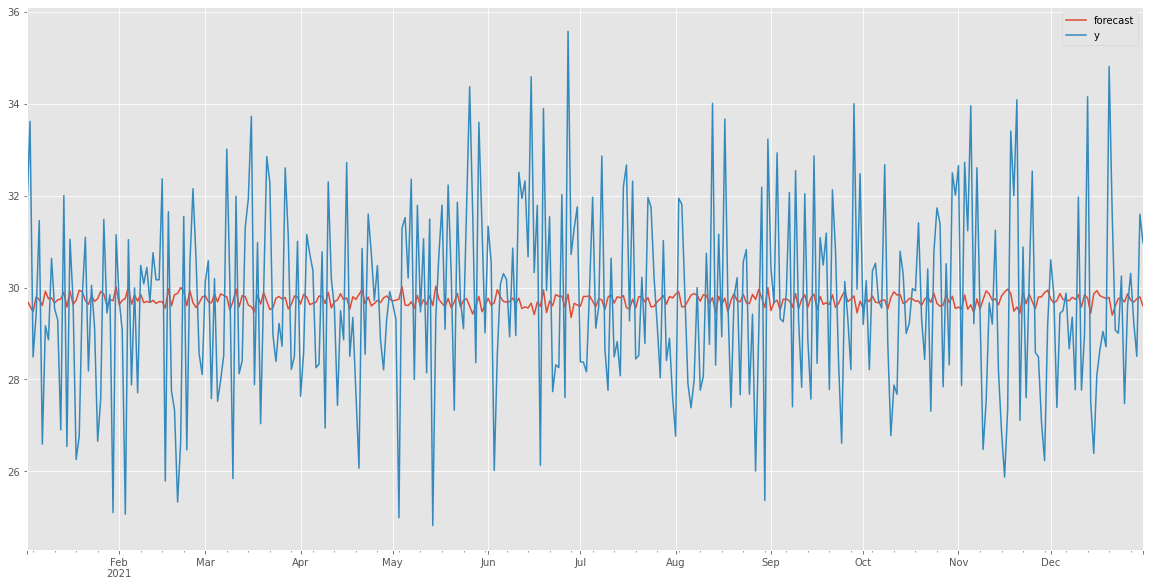

In [26]:
results.plot_predict(dynamic=False)
plt.show()

In [27]:
# Forecast
fc, se, conf = results.forecast(101, alpha=0.05)  # 95% conf

StatementMeta(Sustainability, 6, 23, Finished, Available)

## AQI Forecasting

StatementMeta(Sustainability, 6, 24, Finished, Available)

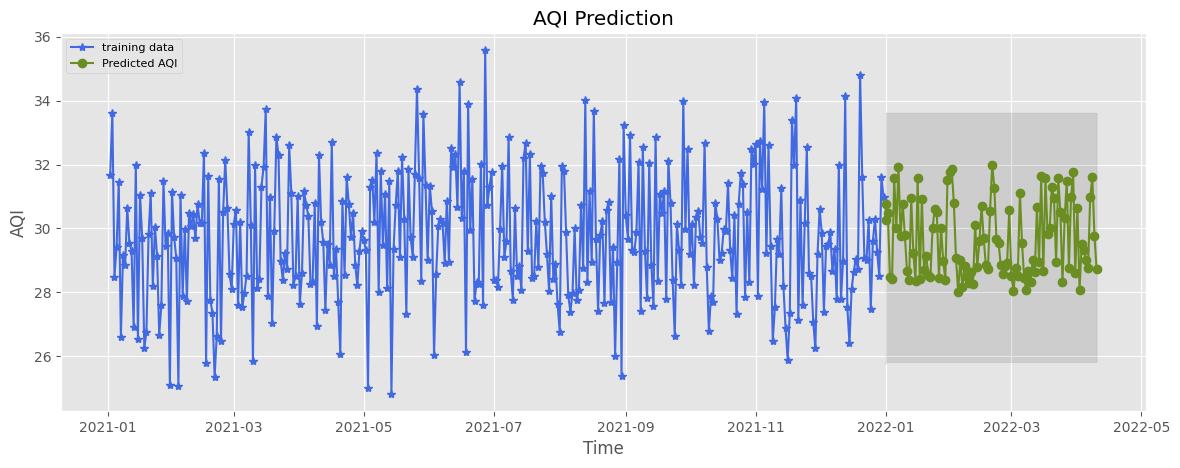

In [28]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(14,5), dpi=100)
plt.plot(train_data, label='training data', color = 'royalblue', marker='*')
plt.plot(test_data, label='Predicted AQI', color = 'olivedrab', marker='o')
#plt.plot(fc_series, color = 'darkolivegreen',label='Predicted AQI')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('AQI Prediction')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend(loc='upper left', fontsize=8)
plt.show()